In [124]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [91]:
df = pd.read_csv("ecommerce_customer_data_large.csv")

In [92]:
df.head()

Customer ID        Purchase Date Product Category  Product Price  Quantity  \
0        44605  2023-05-03 21:30:02             Home            177         1   
1        44605  2021-05-16 13:57:44      Electronics            174         3   
2        44605  2020-07-13 06:16:57            Books            413         1   
3        44605  2023-01-17 13:14:36      Electronics            396         3   
4        44605  2021-05-01 11:29:27            Books            259         4   

   Total Purchase Amount Payment Method  Customer Age  Returns Customer Name  \
0                   2427         PayPal            31      1.0   John Rivera   
1                   2448         PayPal            31      1.0   John Rivera   
2                   2345    Credit Card            31      1.0   John Rivera   
3                    937           Cash            31      0.0   John Rivera   
4                   2598         PayPal            31      1.0   John Rivera   

   Age  Gender  Churn  
0   31  Female      0  
1   31  Female      0  
2   31  Female      0  
3   31  Female      0  
4   31  Female      0

In [93]:
df.columns = df.columns.str.replace(' ', '_')

In [94]:
df.drop(['Age'], axis=1, inplace=True)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Customer_ID            250000 non-null  int64  
 1   Purchase_Date          250000 non-null  object 
 2   Product_Category       250000 non-null  object 
 3   Product_Price          250000 non-null  int64  
 4   Quantity               250000 non-null  int64  
 5   Total_Purchase_Amount  250000 non-null  int64  
 6   Payment_Method         250000 non-null  object 
 7   Customer_Age           250000 non-null  int64  
 8   Returns                202618 non-null  float64
 9   Customer_Name          250000 non-null  object 
 10  Gender                 250000 non-null  object 
 11  Churn                  250000 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 22.9+ MB


In [96]:
df = df.groupby('Customer_ID').agg({
    'Total_Purchase_Amount': ['sum', 'mean', 'count'],
    'Purchase_Date': 'max',  
    'Product_Category': 'nunique',  
    'Returns': 'mean',  
    'Payment_Method': lambda x: x.mode()[0],  
    'Customer_Age': 'first', 
    'Gender': 'first',  
    'Churn': 'first'
}).reset_index()

df.columns = ['Customer ID', 'Total Spend', 'Avg Spend', 'Transaction Count', 'Last Purchase Date', 
                         'Unique Categories', 'Return Rate', 'Frequent Payment Method', 'Age', 'Gender', 'Churn']


In [97]:
df.head()

Customer ID  Total Spend    Avg Spend  Transaction Count  \
0            1         6290  2096.666667                  3   
1            2        16481  2746.833333                  6   
2            3         9423  2355.750000                  4   
3            4         7826  1565.200000                  5   
4            5         9769  1953.800000                  5   

    Last Purchase Date  Unique Categories  Return Rate  \
0  2022-11-29 06:48:25                  3     0.000000   
1  2023-07-03 17:26:19                  4     0.666667   
2  2023-02-03 03:58:07                  3     0.000000   
3  2022-06-29 03:41:09                  4     0.600000   
4  2022-07-16 04:08:09                  2     1.000000   

  Frequent Payment Method  Age  Gender  Churn  
0             Credit Card   67  Female      0  
1                  PayPal   42  Female      0  
2             Credit Card   31    Male      0  
3                    Cash   37    Male      0  
4             Credit Card   24  Female      0

In [98]:
df.isna().sum()

Customer ID                  0
Total Spend                  0
Avg Spend                    0
Transaction Count            0
Last Purchase Date           0
Unique Categories            0
Return Rate                515
Frequent Payment Method      0
Age                          0
Gender                       0
Churn                        0
dtype: int64

In [99]:
df['Return Rate'] = df['Return Rate'].fillna(df['Return Rate'].mean())

In [100]:
df.head()

Customer ID  Total Spend    Avg Spend  Transaction Count  \
0            1         6290  2096.666667                  3   
1            2        16481  2746.833333                  6   
2            3         9423  2355.750000                  4   
3            4         7826  1565.200000                  5   
4            5         9769  1953.800000                  5   

    Last Purchase Date  Unique Categories  Return Rate  \
0  2022-11-29 06:48:25                  3     0.000000   
1  2023-07-03 17:26:19                  4     0.666667   
2  2023-02-03 03:58:07                  3     0.000000   
3  2022-06-29 03:41:09                  4     0.600000   
4  2022-07-16 04:08:09                  2     1.000000   

  Frequent Payment Method  Age  Gender  Churn  
0             Credit Card   67  Female      0  
1                  PayPal   42  Female      0  
2             Credit Card   31    Male      0  
3                    Cash   37    Male      0  
4             Credit Card   24  Female      0

In [128]:
df.drop(['Customer ID', 'Last Purchase Date'], axis=1, inplace=True)

In [129]:
numerical_features = ['Total Spend', 'Avg Spend', 'Transaction Count', 'Age', 'Unique Categories']
categorical_features = ['Frequent Payment Method', 'Gender']

In [140]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  
        ('cat', OneHotEncoder(), categorical_features)  
    ],
    remainder='passthrough')

In [141]:
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

In [142]:
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

In [143]:
X = df.drop('Churn', axis=1)  # Features
y = df['Churn']  # Target

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [145]:
pipeline_lr.fit(X_train, y_train)


y_pred_lr = pipeline_lr.predict(X_test)


print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_lr)}")

Accuracy: 0.497214578159608
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.50      0.61     11920
           1       0.20      0.50      0.28      2979

    accuracy                           0.50     14899
   macro avg       0.50      0.50      0.45     14899
weighted avg       0.68      0.50      0.55     14899



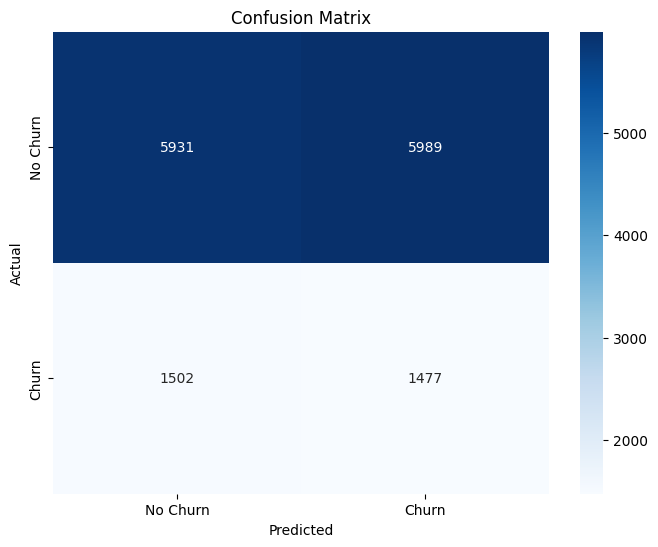

In [146]:
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [147]:
pipeline_rf.fit(X_train, y_train)


y_pred_rf = pipeline_rf.predict(X_test)


print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_rf)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, pipeline_rf.predict_proba(X_test)[:, 1])}")

Accuracy: 0.7889120075172831
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.98      0.88     11920
           1       0.21      0.02      0.04      2979

    accuracy                           0.79     14899
   macro avg       0.51      0.50      0.46     14899
weighted avg       0.68      0.79      0.71     14899

ROC AUC Score: 0.5038449938157709


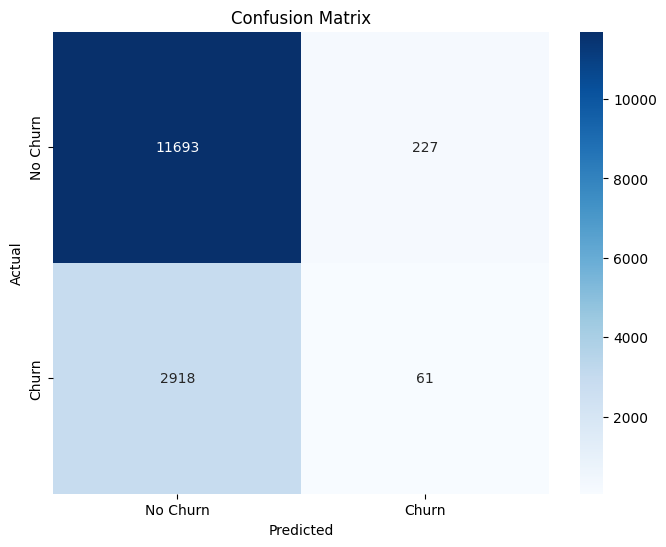

In [148]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()